<a href="https://colab.research.google.com/github/Saran-nns/incremental_learning_tf2.0/blob/master/incremental_learning_model_wrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import Model

### Data

In [0]:
dataset = datasets.cifar10.load_data()

In [0]:
def custom_dataset_loader(dataset = dataset, allowed_labels =None):
  
  filtered_training_data = []
  filtered_labels = []
  # Pick only the data with required labels
  for i, _ in enumerate(dataset[0][0]):
    if dataset[0][1][i] in allowed_labels:
      filtered_training_data.append(dataset[0][0][i]/np.float32(255))
      filtered_labels.append(dataset[0][1][i])

  train_dataset = tf.data.Dataset.from_tensor_slices((filtered_training_data, filtered_labels))
  # TODO: new_dataset = train_dataset+old_dataset
  train_dataset.shuffle(len(list(train_dataset)))

  # Split into train and test (80%, 20%)
  trainind_dataset_size = int(len(list(train_dataset))*0.8)
  train_ds,test_ds = train_dataset.take(trainind_dataset_size), train_dataset.skip(trainind_dataset_size)

  # Split the images and labels in train and test datasets
  train_images,train_labels= np.array(list(train_ds))[:,0],np.array(list(train_ds))[:,1]
  train_images,train_labels = tf.convert_to_tensor(train_images.tolist()), tf.convert_to_tensor(train_labels.tolist())
  test_images,test_labels = np.array(list(test_ds))[:,0],np.array(list(test_ds))[:,1]
  test_images,test_labels = tf.convert_to_tensor(test_images.tolist()),tf.convert_to_tensor(test_labels.tolist())
  print('Shape of training images after filtering labels',np.shape(train_images))

  return train_images,train_labels,test_images,test_labels

### Model

In [0]:
class FeatureExtractor(Model):
  def __init__(self,trainable):
    super(FeatureExtractor, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu',trainable = trainable)
    self.maxpool = MaxPooling2D((2,2))
    self.conv2 = Conv2D(64, 3, activation='relu',trainable = trainable)
    self.conv3 = Conv2D(64,3,activation='relu',trainable = trainable)
  def call(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    return x

class Classifier(Model):
  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.flatten = Flatten()
    self.n_classes = n_classes
    self.d1 = Dense(64, activation='relu')
    self.d2 = Dense(n_classes)

  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

class IncrementalLearning(Model):
  def __init__(self, feature_extractor,classifier, is_online = False):
    super(IncrementalLearning, self).__init__()
    self.feature_extractor=feature_extractor
    if is_online:
      self.feature_extractor.trainable = False
      # Clone the old classifier weights and  set it non-trainable
      classifier.trainable = False
      # Add new prediction layer and set it trainable
      self.new_prediction_layer = tf.keras.layers.Dense(classifier.n_classes,trainable=True)
      self.classifier= tf.keras.Sequential([classifier, self.new_prediction_layer])
    else:
      self.classifier = classifier

  def call(self, x):
    features = self.feature_extractor(x)
    x = self.classifier(features)

    return x

In [0]:
x = Classifier(10)
x.build((64,))
var= [var.name for var in x.trainable_variables]
var

['dense/kernel:0', 'dense/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0']

In [0]:
feature_extractor = FeatureExtractor(trainable=True)
classifier = Classifier(10)
model = IncrementalLearning(feature_extractor,classifier,is_online=False)

In [0]:
model.build((None,32,32,3))

In [0]:
model.summary()

Model: "incremental_learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (FeatureEx multiple                  56320     
_________________________________________________________________
classifier_1 (Classifier)    multiple                  66250     
Total params: 122,570
Trainable params: 122,570
Non-trainable params: 0
_________________________________________________________________


In [0]:
feature_extractor1 = FeatureExtractor(trainable=False)
classifier1 = Classifier(10)
model2 = IncrementalLearning(feature_extractor,classifier,is_online=True)


In [0]:
model2.build((None,32,32,3))
model2.summary()

Model: "incremental_learning_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (FeatureEx multiple                  56320     
_________________________________________________________________
dense_6 (Dense)              multiple                  110       
_________________________________________________________________
sequential (Sequential)      multiple                  66360     
Total params: 122,680
Trainable params: 110
Non-trainable params: 122,570
_________________________________________________________________


### Training Loop


#### Dataloader

In [0]:
old_labels = [0,1,2,3,4,5,6,7]
new_labels = []
allowed_labels = old_labels + new_labels
train_images,train_labels,test_images,test_labels = custom_dataset_loader(dataset = dataset, 
                                                                          allowed_labels = allowed_labels)

Shape of training images after filtering labels (32000, 32, 32, 3)


#### Checkpoints and Callbacks

In [0]:
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  """To visualize batch wise training progress
  NOTE: Batch wise stats slow down the training progress as well"""
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

#### Train using Mirror strategy

In [0]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

  feature_extractor = FeatureExtractor(trainable=False)
  classifier = Classifier(n_classes=8)
  model = IncrementalLearning(feature_extractor,classifier,is_online = True)
  batch_stats_callback = CollectBatchStats()
  # Compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['acc'])

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
  # Train the model
  history = model.fit(train_images, train_labels, epochs=10, 
                      validation_data=(test_images, test_labels),callbacks=[cp_callback, batch_stats_callback])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replic

### Evaluate

250/250 - 1s - acc: 0.2362 - loss: 2.0170


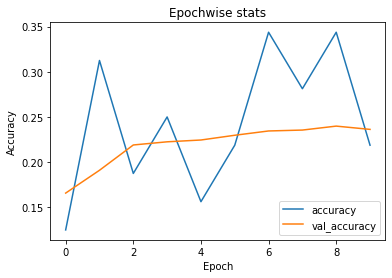

In [0]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend()
plt.title('Epochwise stats')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

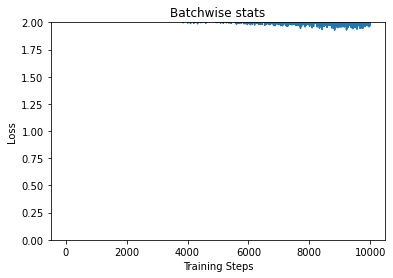

In [0]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.title('Batchwise stats')
plt.plot(batch_stats_callback.batch_losses)

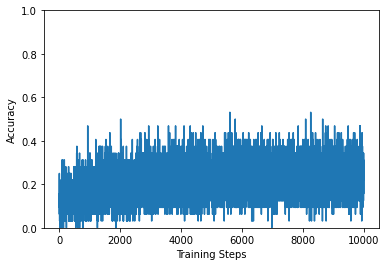

In [0]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Train using Pretrained feature extractor model (ResNet)

In [0]:
feature_extractor = tf.keras.applications.ResNet50()

#### Custom classifier layer since the output size from ResNet is unknown

In [0]:
class CustomClassifier(layers.Layer):

  def __init__(self, units=64,n_classes = 10):
    super(CustomClassifier, self).__init__()
    self.units = units
    self.n_classes = n_classes

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer='random_normal',
                             trainable = True)
    self.b = self.add_weight(shape=(self.units,),
                             initializer='random_normal',
                             trainable = True)

  def call(self, inputs):
    return tf.nn.relu(tf.matmul(inputs, self.w) + self.b)

In [0]:
# This custom classifier is assumed to be pretrained. A new classifier layer will be created and will be set to trainable
# while instantiating IncrementalLearning class
custom_classifier = CustomClassifier(n_classes = 8)
model = IncrementalLearning(feature_extractor,custom_classifier,is_online=True)

In [0]:
model.build((None,32,32,3))
model.summary()

Model: "incremental_learning_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
dense_10 (Dense)             multiple                  520       
_________________________________________________________________
sequential_2 (Sequential)    multiple                  64584     
Total params: 25,701,296
Trainable params: 520
Non-trainable params: 25,700,776
_________________________________________________________________


#### Train only the classifier
Note: There is a part of classifier already trained at previous run;
Therefore, by adding new classifier inside incremental learning instance, will set the previous sequential layer of classifier False. Only the new instance of the 

In [0]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

  feature_extractor = FeatureExtractor(trainable=False)
  classifier = Classifier(n_classes=8)
  model = IncrementalLearning(feature_extractor,classifier,is_online = True)
  batch_stats_callback = CollectBatchStats()
  # Compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['acc'])

  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
  # Train the model
  history = model.fit(train_images, train_labels, epochs=10, 
                      validation_data=(test_images, test_labels),callbacks=[cp_callback, batch_stats_callback])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/10
 994/1000 [============================>.] - ETA: 0s - acc: 0.1250 - loss: 2.0758
Epoch 00001: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 6s 6ms/step - acc: 0.1250 - loss: 2.0883 - val_acc: 0.1433 - val_loss: 2.0758
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - acc: 0.0625 - loss: 2.0812
Epoch 00002: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 6s 6ms/step - acc: 0.0625 - loss: 2.0812 - val_acc: 0.1864 - val_loss: 2.0699
Epoch 3/10
 995/1000 [============================>.] - ETA: 0s - acc: 0.1562 - loss: 2.0617
Epoch 00003: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 6s 6ms/step - acc: 0.1875 - loss: 2.0621 - val_acc: 0.1807 - val_loss: 2.0643
Epoch 4/10
 987/1000 [============================>.] - ETA: 0s - acc: 0.1562 - loss: 2.0829
Epoch 00004: 